# Offline Feature selection for all models

### Importing Libraries

In [109]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from imblearn.ensemble import BalancedRandomForestClassifier # pip install imblearn - scikit wrapper
from sklearn.feature_selection import SelectPercentile, chi2, f_classif

from helpers import load_data, roc_plt, NeuralNetwork, make_model, aggregated_roc_plt

### Importing data

In [115]:
##load the data 

DATA_PATH = '../data/'
PICKLE_PATH = '../pickles/'
IMG_PATH = '../imgs/'
seed = 7

master_data = load_data(DATA_PATH)
X, y = master_data['muchlinski']

In [62]:
def get_params(method):
    file = "gs_rocauc_" + method +"_all.pkl"
    with open(PICKLE_PATH + file, "rb") as f:
        params = pickle.load(f)
        params = params.drop('roc_auc',axis=1).iloc[0].to_dict()
    if method == "svm" and np.isnan(params["degree"]):
        params["degree"] = 1
    if "n_estimators" in params:
        params["n_estimators"] = int(params["n_estimators"])
    return params

def save_pkl(object_, file):
    with open(PICKLE_PATH + file + ".pkl", "wb") as f:
        pickle.dump(object_, f, pickle.HIGHEST_PROTOCOL)
        
def load_pkl(file, df=True):
    with open(PICKLE_PATH + file + ".pkl", "rb") as f:
        pkl_obj = pd.DataFrame(pickle.load(f)) if df else pickle.load(f)
    return pkl_obj

### Creating the models

In [23]:
params_brf = get_params("brf")
params_bdt = get_params("bdt")
params_knn = get_params("knn")
params_svm = get_params("svm")
params_nn = get_params("nn")

BRF = BalancedRandomForestClassifier(random_state = 0)
KNN = KNeighborsClassifier()
SVM = SVC(random_state = 0)
BDT = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(), random_state = 0)

BRF.set_params(**params_brf)
KNN.set_params(**params_knn)
SVM.set_params(**params_svm)
BDT.set_params(**params_bdt)

STD = StandardScaler()

In [24]:
def categorical_filter(df, low_exclusive = 2, high_inclusive = 15):
    """function returns features (col_names) that have unique values
    less than or equal to n_categories

    """
    list_of_features = []
    for i in df.columns:
        k = sorted(df[i].unique())
        if k[0] < 0 or all(isinstance(x, np.int64) for x in k) == False:
            continue

        if low_exclusive == high_inclusive:
            if df[i].nunique() <= low_exclusive :
                list_of_features.append(i)
        else:
            if high_inclusive >= df[i].nunique() > low_exclusive :
                list_of_features.append(i)
    return list_of_features

In [25]:
def get_col_indexes(df, cols):
    return [df.columns.get_loc(c) for c in cols if c in df]

In [26]:
cat = categorical_filter(X, 1, 15)
num = X.columns.difference(cat)

num_str = num.copy()
cat_Str = cat.copy()

cat = get_col_indexes(X, cat)
num = get_col_indexes(X, num)

In [44]:
from sklearn.compose import make_column_transformer

ct = make_column_transformer((StandardScaler(), num), remainder='passthrough')

chi =  SelectPercentile(chi2, percentile=30)
ano = SelectKBest(f_regression, k=22)

fe = ColumnTransformer(
    transformers=[
        ('num', ano, [*range(len(num))]),
        ('cat', chi, [*range(len(num) + 1, len(num) + len(cat))])])

In [45]:
X_tr = ct.fit_transform(X)
X_tr = fe.fit_transform(X_tr, y)

NN = NeuralNetwork(build_fn=make_model, nr_features=X_tr.shape[-1], verbose=0, **params_nn)
NN._estimator_type = "classifier"

### Creating the pipelines

In [46]:
pipe_BRF = Pipeline([('std',ct), ('fe',fe), ('clf',BRF)])
pipe_KNN = Pipeline([('std',ct), ('fe',fe), ('clf',KNN)])
pipe_SVM = Pipeline([('std',ct), ('fe',fe), ('clf',SVM)])
pipe_BDT = Pipeline([('std',ct), ('fe',fe), ('clf',BDT)])
pipe_NN = Pipeline([('std',ct), ('fe',fe), ('clf',NN)])

### Plotting & saving plot results to aggregate

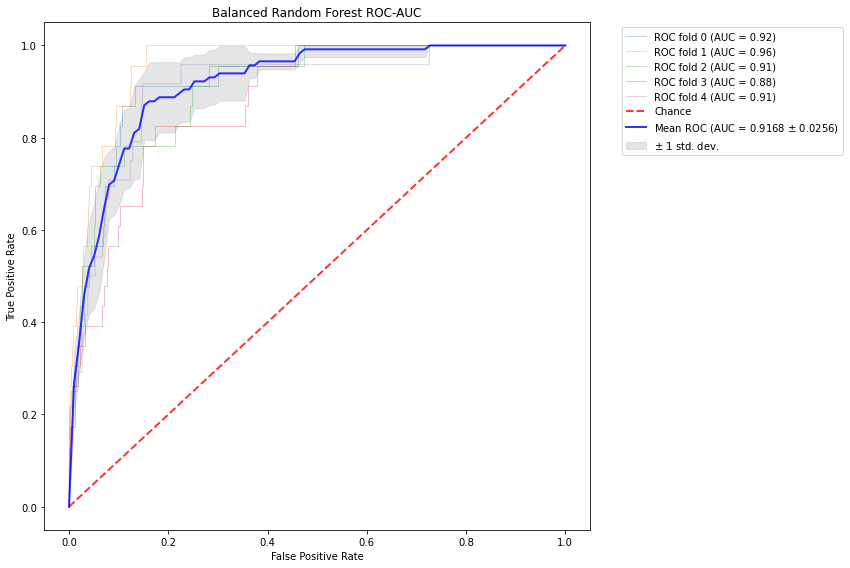

In [47]:
brf_res = roc_plt(X, y, pipe_BRF, "Balanced Random Forest ROC-AUC", seed=seed, create_plot=True)
save_pkl(brf_res, "brf_res_off_fs")

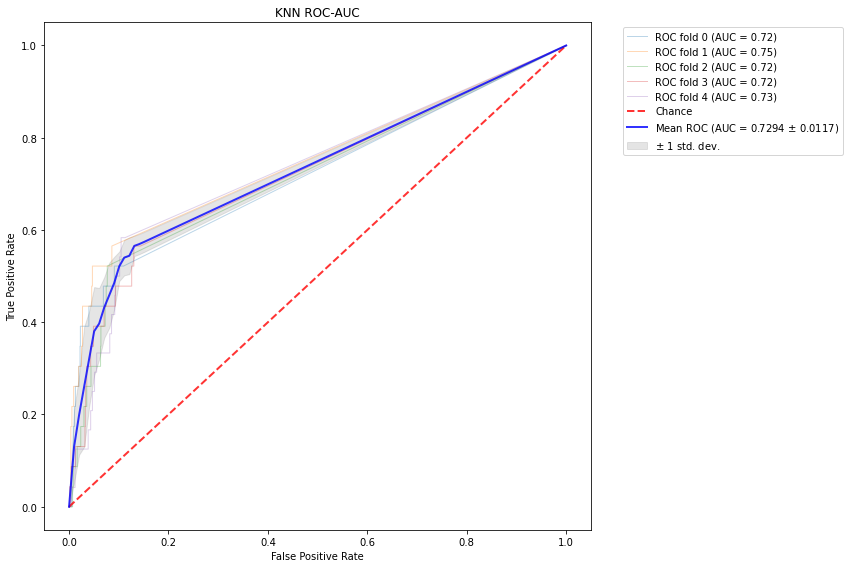

In [48]:
knn_res = roc_plt(X, y, pipe_KNN, "KNN ROC-AUC", seed=seed, create_plot=True)
save_pkl(knn_res, "knn_res_off_fs")

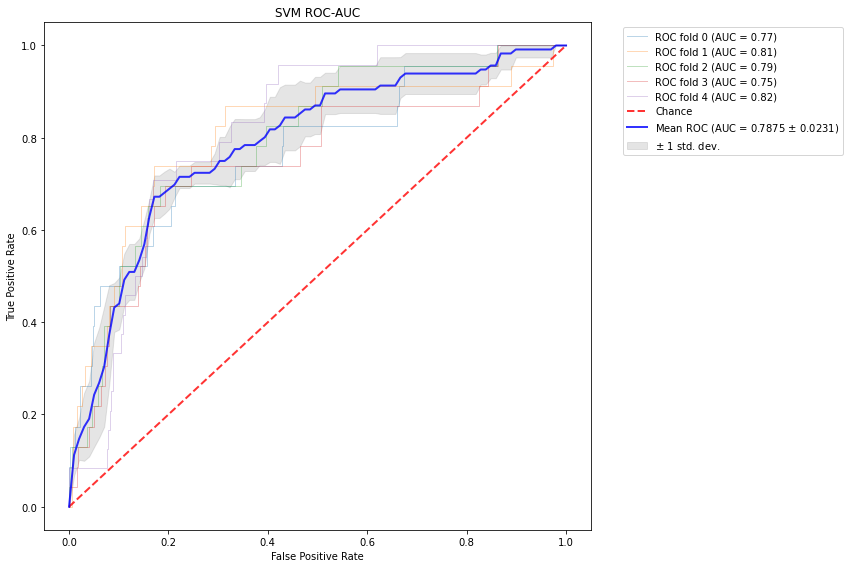

In [49]:
svm_res = roc_plt(X, y, pipe_SVM, "SVM ROC-AUC", seed=seed, create_plot=True)
save_pkl(svm_res, "svm_res_off_fs")

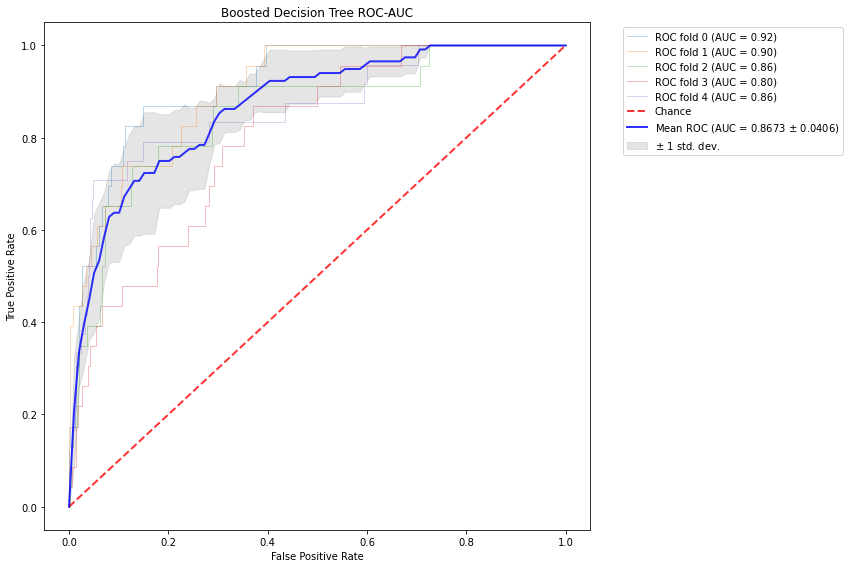

In [50]:
bdt_res = roc_plt(X, y, pipe_BDT, "Boosted Decision Tree ROC-AUC", seed=seed, create_plot=True)
save_pkl(bdt_res, "bdt_res_off_fs")

/home/kamran/anaconda3/envs/ada/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/home/kamran/anaconda3/envs/ada/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/home/kamran/anaconda3/envs/ada/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/home/kamran/anaconda3/envs/ada/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:4

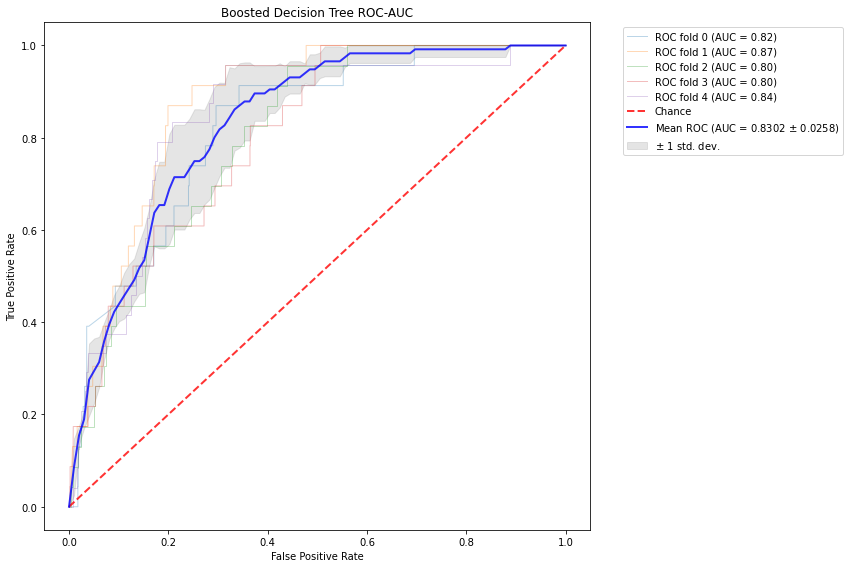

In [51]:
nn_res = roc_plt(X, y, pipe_NN, "Boosted Decision Tree ROC-AUC", seed=seed, create_plot=True)
save_pkl(nn_res, "nn_res_off_fs")

### Final Plot

In [100]:
k_folds = 5

bdt_res = load_pkl("bdt_res_off_fs")
bdt_res['clf'] = 'Boosted Decision Trees'
svm_res = load_pkl("svm_res_off_fs")
svm_res['clf'] = 'Support Vector Machine'
brf_res = load_pkl("brf_res_off_fs")
brf_res['clf'] = 'Balanced Random Forest'
knn_res = load_pkl("knn_res_off_fs")
knn_res['clf'] = 'K-Nearest Neighbors'
nn_res = load_pkl("nn_res_off_fs")
nn_res['clf'] = 'Neural Network'

rocauc_res = pd.concat([svm_res, bdt_res, knn_res, brf_res, nn_res])
rocauc_res['Classifier'] = rocauc_res['clf'] + ' : Auc Score: ' + rocauc_res['mean_auc'].round(4).astype(str)
rocauc_res = rocauc_res.sort_values('mean_auc', ascending=False)

model_names = ['Boosted Decision Trees','Support Vector Machine','Balanced Random Forest','K-Nearest Neighbors','Neural Network']
colors = dict(zip(model_names, sns.color_palette("colorblind",5))) 
colors = {k: colors[k] for k in rocauc_res['clf'].unique().tolist()}

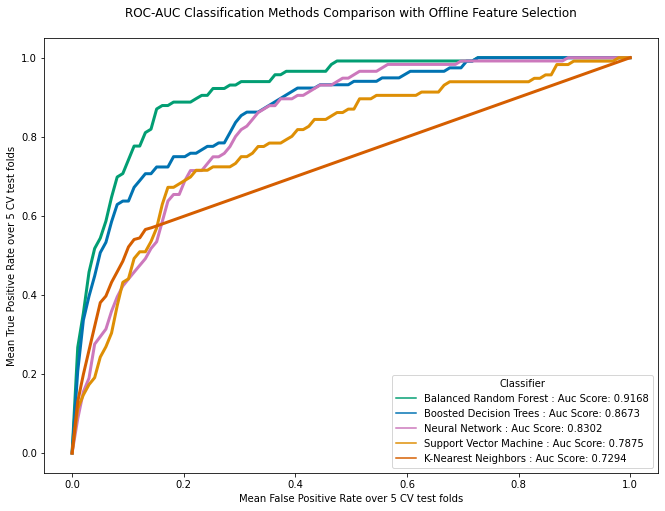

In [117]:
aggregated_roc_plot(rocauc_res, list(colors.values()), 'ROC-AUC Classification Methods Comparison with Offline Feature Selection\n', IMG_PATH+'roc_off_fs.pdf')